In [1]:
import sys
sys.path.insert(0, '/tigress/architv/drug-lfm/point-processes/beta-prior')
from cpp2g import CPP2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
plt.style.use('seaborn-poster')

In [4]:
from scipy.io import loadmat

In [5]:
learned = np.load('learned-103120.npz')
dat = loadmat('/tigress/architv/ORGANIZED_CODE_FOR_UPLOAD/tapi_dose.mat')

In [6]:
learned['note']

array('cpp2g - epsilon = 60, init with mu = half control mu, a = half control mu, b = .01*ones, bjj = 1, model with self',
      dtype='<U113')

In [7]:
tapi_concentrations = np.array([0,0,0,0, 5,5,5,5,5, 10,10,10,10,10, 20,20,20,20,20])
cs = np.unique(tapi_concentrations)

In [8]:
dat = loadmat('/tigress/architv/ORGANIZED_CODE_FOR_UPLOAD/tapi_dose.mat')

In [9]:
control_mu = np.zeros(20)
for i in range(20):
    well = i
    traces = dat['well'][0][well]['PeakTimes']
    peaks = 0
    for j in range(len(traces[0])):
        peaks += len(traces[0][j])
    x = dat['well'][0][well]['x']
    control_mu[i] = peaks/(480. * x.shape[1])

In [10]:
control_likelihood = np.zeros(20)

In [11]:
lpp = CPP2()

In [12]:
learned['epsilon'][0,1]

60.0

In [13]:
for i in range(1,20):
    well = i
    t = dat['well'][0][well]['t']
    traces = dat['well'][0][well]['PeakTimes']
    events = []
    for j in range(len(traces[0])):
        events.append(np.reshape(traces[0][j],-1).astype(np.float64))
    x = dat['well'][0][well]['x']
    y = dat['well'][0][well]['y']
    coords = np.vstack((x[0],y[0])).T
    
    lpp = CPP2()
    
    
    lpp.input_data(events, coords, np.zeros(coords.shape[0], dtype = np.int))
    lpp.set_init(nclusters = 1, mu_init = control_mu[i] * np.ones((1,)), 
                 a_init = np.zeros((1,1)), ajj_init = np.zeros((1,)),
                 b_init = learned['b'][0,i,0,0] * np.ones((1,1)),
                 epsilon_init = learned['epsilon'][0,i], tmax = 480)
    lpp.sharpness = 1
    control_likelihood[i] = lpp.negLogL_with_self(lpp.y_sorted, lpp.cells_sorted, lpp.d, lpp.clusters,
                                       control = True).data

/tigress/architv/drug-lfm/point-processes/beta-prior/cpp2g.py:21: RuntimeWarning: divide by zero encountered in log
  return np.log(np.exp(x) - 1)


In [14]:
lr_diff = (-learned['likelihood'][0]) - (-control_likelihood)

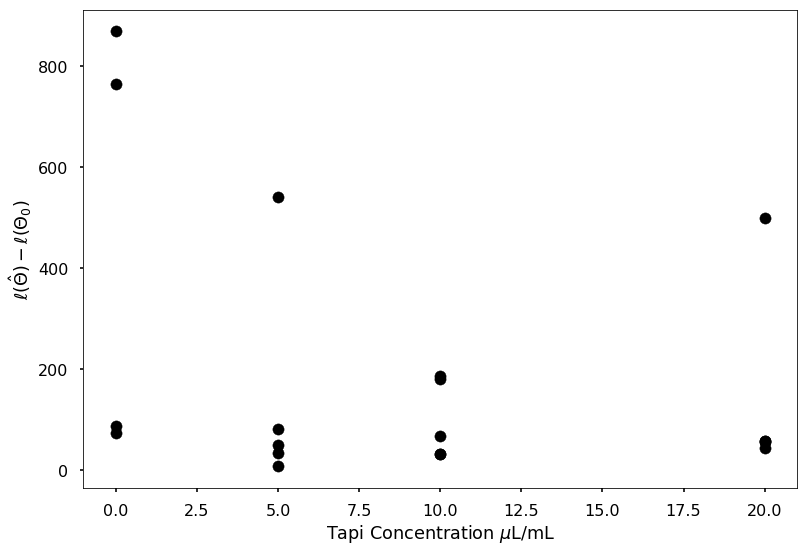

In [15]:
plt.scatter(tapi_concentrations, lr_diff[1:], c = 'k')
plt.xlabel('Tapi Concentration $\mu$L/mL')
plt.ylabel('$\ell(\hat{\Theta})-\ell(\Theta_0)$')
plt.savefig('tapi-likelihood-103120.pdf')

In [16]:
learned['likelihood'][0]

array([   0.        , 4799.47802734, 4633.29101562, 5000.68994141,
       4800.99609375, 5113.40820312, 4393.29833984, 5587.16699219,
       2908.99707031, 1842.74658203, 5202.91210938, 5198.99902344,
       4586.03027344, 5034.30078125, 5184.203125  , 4432.85693359,
       4385.29150391, 3987.93115234, 5220.36474609, 4683.3125    ])